<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
!pip install -U scikeras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay


## Read OHLC, Features, and Target

In [4]:
Ohlc = pd.read_parquet( root / '1. ohlc.parquet' )

Features = pd.read_parquet( root / '2. features.parquet' )
Features.head()

,sma(30),ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiSma(14),rsiEma(14),mfi(14)
Date,,,,,,,,,
2024-10-30,65422.667667,66722.644315,1.0,72663.833481,62161.088519,420.346515,66.640357,75.020891,57.711120
2024-10-31,65735.273667,66955.221805,1.0,72638.366976,62963.565024,310.777749,58.735537,58.709448,56.491327
2024-11-01,66030.263000,67123.168955,1.0,72486.842207,63744.034793,166.342215,53.360096,54.033862,47.100807
2024-11-02,66314.592000,67266.837741,1.0,72060.759885,64813.906115,41.115159,52.901738,52.755618,43.712170
2024-11-03,66537.046667,67364.444311,1.0,72017.142810,65127.022190,-87.963996,49.179247,48.963673,38.483594


In [5]:
Target = pd.read_parquet( root / '2. target.parquet' )
Target = Target.squeeze()
Target.head()

,Target
Date,
2024-10-30,0
2024-10-31,0
2024-11-01,0
2024-11-02,0
2024-11-03,0


In [6]:
print( len(Features), len(Target) )
print( Features.isnull().sum().sum(), Target.isnull().sum() )

Target.value_counts()

315 315
0 0


,count
Target,
1,160
0,155


## Train Test Split

In [7]:
def create_sequences(X, y, window):
  Xs, ys = [], []
  for i in range(len(X) - window):
    Xs.append( X[ i:(i+window) ] )
    ys.append( y[ i+window ] )
  return np.array(Xs), np.array(ys)


# normalize with standardScaler
scaler = StandardScaler()
X = scaler.fit_transform( Features.values )

train_size_ratio = 0.8
window           = 50

X_seq, y_seq = create_sequences( X, Target.values, window )
train_size = int( len(X_seq) * train_size_ratio )
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]



In [8]:
# check multivariate timeseries shape
X_train.shape, y_train.shape

((212, 50, 9), (212,))

## Plot Utilities

In [9]:
def plotRocCurve( y_test, y_pred ):
  """ plot roc curve """
  fpr, tpr, _ = roc_curve( y_test, y_pred )
  auc = roc_auc_score( y_test, y_pred )

  fig, ax = plt.subplots(1, 1, figsize=(14, 10))
  ax.plot( fpr, tpr, label=f"AUC={auc:.2f}" )
  ax.plot( [0,1], [0,1], 'k--' )
  ax.set_xlabel( "False Positive Rate" )
  ax.set_ylabel( "True Positive Rate" )
  ax.set_title( "ROC Curve" )
  ax.legend()
  plt.show()


def plotPredVsTrue( y_test, y_pred, raw, rawCol ):
  """ plot predictions vs. true values """

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

  xindex = raw.index[-len(y_test):]
  top = {
      'y_test': y_test,
      'y_pred': y_pred,
  }
  bottom = {
      rawCol : raw.loc[ xindex ],
  }

  for label, vals in top.items():
    ax1.plot( xindex, vals, label=label )

  for label, vals in bottom.items():
    ax2.plot( vals )

  for ax in [ax1, ax2]:
    ax.legend()
    ax.grid(True)

  plt.show()


## Simple Neural Network

/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4737 - loss: 0.7508
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5770 - loss: 0.6695
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6090 - loss: 0.6675
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5589 - loss: 0.6513
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7119 - loss: 0.5904
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7094 - loss: 0.5981
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7170 - loss: 0.5627
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.5525
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6784 - loss: 0.5788
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7064 - loss: 0.5646
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7200 - loss: 0.5581
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accurac

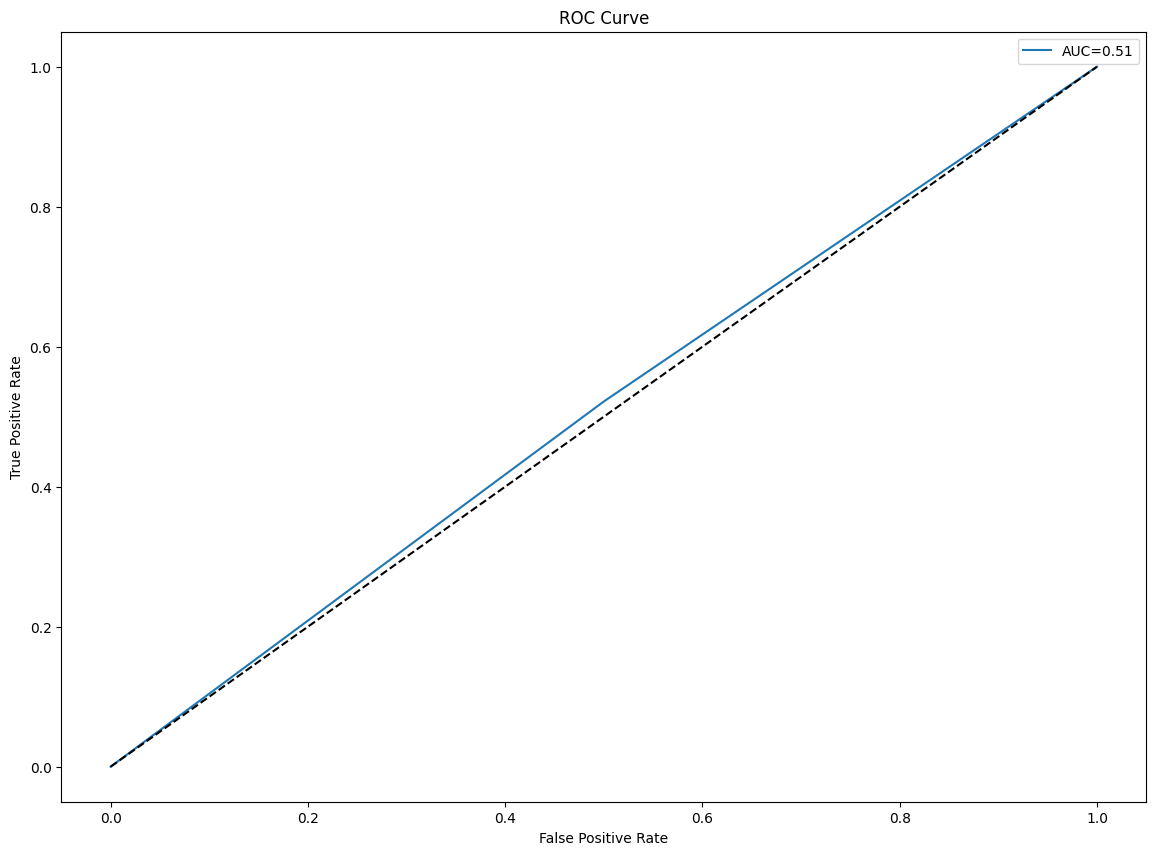

/tmp/ipython-input-4269467548.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


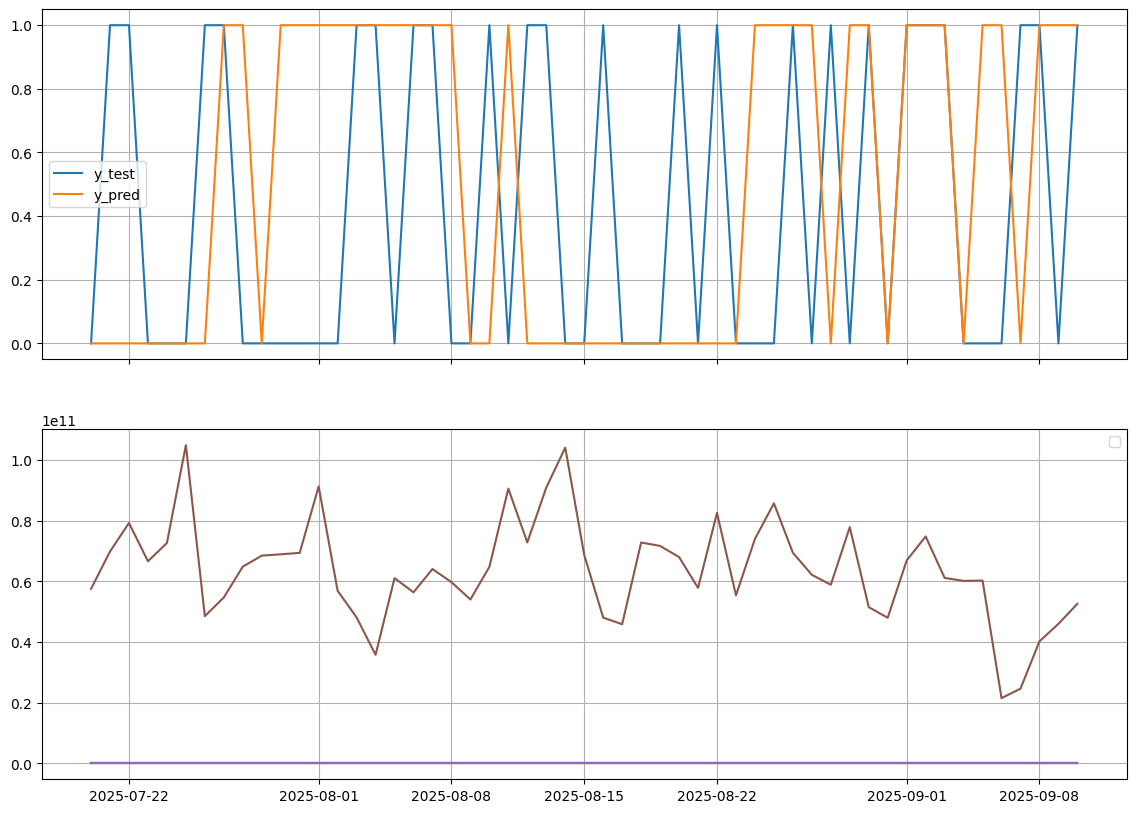

In [10]:
def make_build_fun( input_shape ):
  def build_fn():
    model = Sequential()
    model.add( Flatten(input_shape=input_shape ))
    model.add( Dense(16, activation='tanh' ))
    model.add( Dense(8, activation='relu' ))
    model.add( Dense(4, activation='relu' ))
    model.add( Dense(1, activation='sigmoid' ))

    model.compile(
        optimizer = 'adam',
        loss      = 'binary_crossentropy',
        metrics   = ['accuracy'],
    )
    return model

  return build_fn


build_fn = make_build_fun( X_train.shape[1:] )

clf = KerasClassifier( build_fn=build_fn, epochs=100, batch_size=10, verbose=1 )
clf.fit( X_train, y_train )
y_pred = clf.predict(X_test).ravel()

plotRocCurve( y_test, y_pred )
plotPredVsTrue(  y_test, y_pred, Ohlc, 'Close' )



## LSTM

/usr/local/lib/python3.12/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3981 - loss: 0.7151
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5769 - loss: 0.6889
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5413 - loss: 0.6880
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6466 - loss: 0.6840
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5765 - loss: 0.6841
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5378 - loss: 0.6852
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5513 - loss: 0.6824
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5595 - loss: 0.6819
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5459 - loss: 0.6860
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5770 - loss: 0.6776
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5938 - loss: 0.6705
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

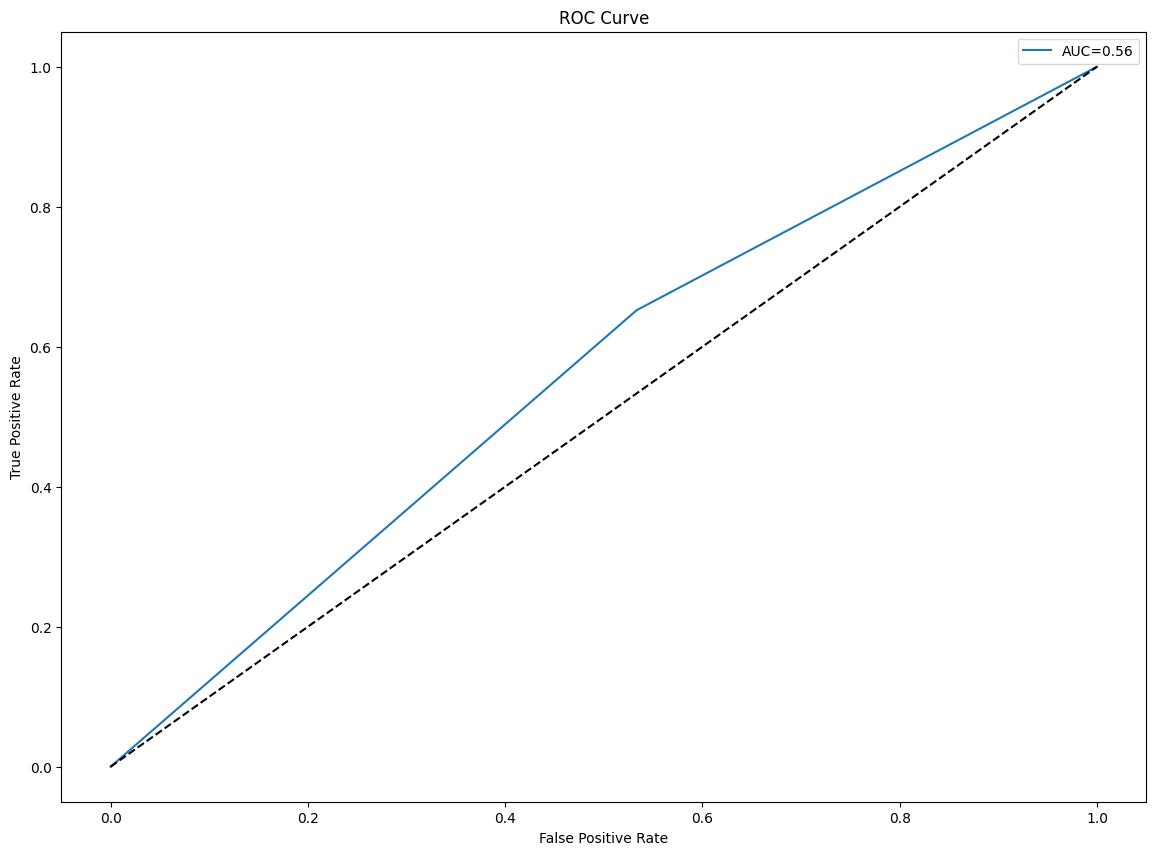

/tmp/ipython-input-4269467548.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


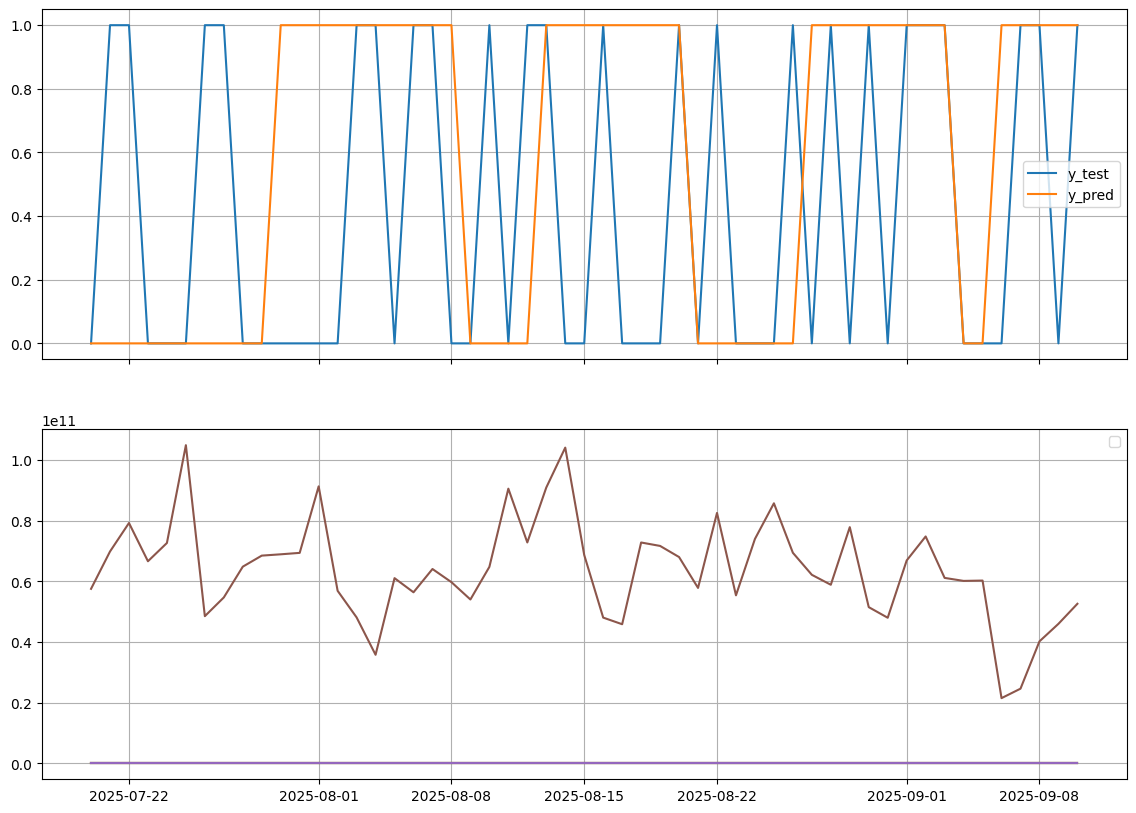

In [11]:
def make_build_fn( input_shape ):
  """ closure to make function """

  def build_fn():
    """ build function """

    model = Sequential()
    model.add( LSTM( 32, activation='tanh', input_shape=input_shape ))
    model.add( Dense( 16, activation='relu' ))
    model.add( Dense( 8, activation='relu' ))
    model.add( Dense( 1, activation='sigmoid' ))

    model.compile(
        optimizer = 'adam',
        loss      = 'binary_crossentropy',
        metrics   = ['accuracy'],
    )
    return model

  return build_fn


build_fn = make_build_fn( X_train.shape[1:] )

clf = KerasClassifier( build_fn=build_fn, epochs=100, batch_size=10, verbose=1 )
clf.fit( X_train, y_train )
y_pred = clf.predict( X_test ).ravel()

plotRocCurve( y_test, y_pred )
plotPredVsTrue(  y_test, y_pred, Ohlc, 'Close' )

## Transformer

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4703 - loss: 0.7152
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4787 - loss: 0.7041
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5406 - loss: 0.6915
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5441 - loss: 0.6888
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5611 - loss: 0.6842
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5500 - loss: 0.6868
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5448 - loss: 0.6916
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6116 - loss: 0.6805
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5601 - loss: 0.6820
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5579 - loss: 0.6815
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5617 - loss: 0.6870
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5832 - loss: 0.6748
E

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


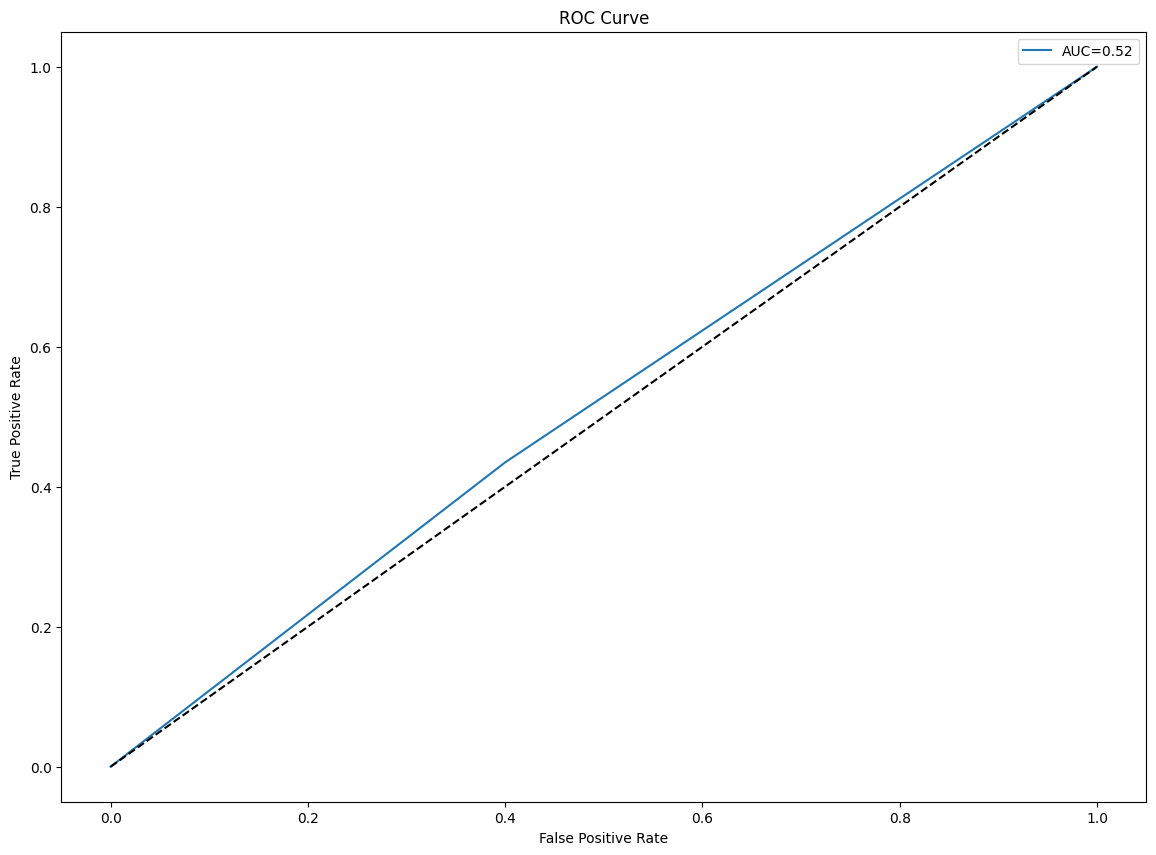

/tmp/ipython-input-4269467548.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


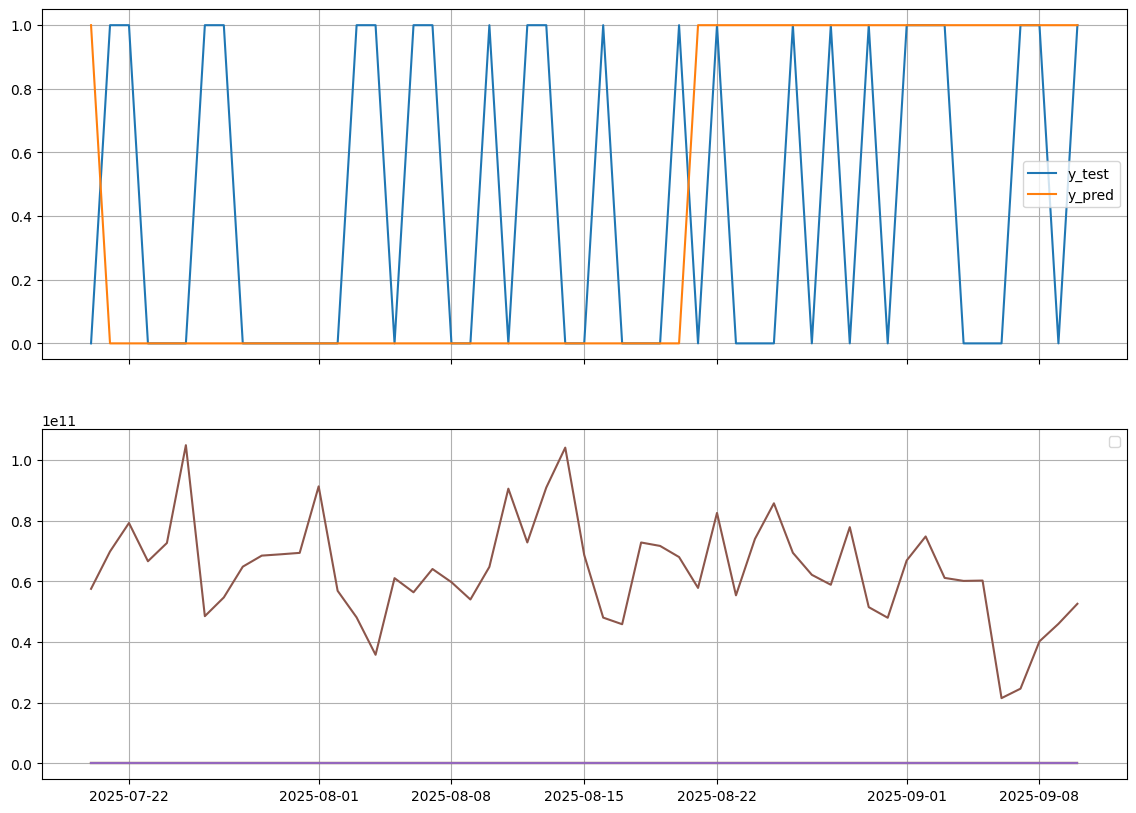

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential as SequentialTFK

def build_transformer_model(timesteps, num_features, num_heads=4, ff_dim=64):

    inputs = layers.Input(shape=(timesteps, num_features))

    # Positional Embedding Layer
    positions = tf.range(start=0, limit=timesteps, delta=1)
    pos_embedding = layers.Embedding(input_dim=timesteps, output_dim=num_features)(positions)
    pos_embedding = tf.expand_dims(pos_embedding, axis=0)        # shape (1, T, F)
    pos_embedding = tf.cast(pos_embedding, dtype=inputs.dtype)

    x = inputs + pos_embedding                                  # Broadcasting works now

    # Transformer Encoder Block
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=num_features)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization( epsilon=0.000001 )(x)

    ff = SequentialTFK([
        layers.Dense(ff_dim, activation="relu"),
        layers.Dense(num_features),
    ])
    x2 = ff(x)
    x = layers.Add()([x, x2])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Global pooling for classification
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer = tf.keras.optimizers.Adam( learning_rate=0.001 ),
        loss      = "binary_crossentropy",
        metrics   = ["accuracy"],
    )
    return model


clf = build_transformer_model(
    timesteps=X_train.shape[1],
    num_features=X_train.shape[2]
)

clf.fit(
    X_train, y_train,
    #validation_split=0.2,
    epochs=50,
    batch_size=32,
)

y_pred = clf.predict(X_test).ravel()
y_pred = (y_pred >= 0.5).astype( int )

plotRocCurve( y_test, y_pred )
plotPredVsTrue(  y_test, y_pred, Ohlc, 'Close' )


## Conclusions & Future Exploration

1. Predicting short-term asset price direction is inherently difficult.
Markets are noisy, regime-shifting, and heavily influenced by external factors that aren't fully captured in price history alone. Even achieving accuracy slightly above randomness (~50%) requires careful feature engineering, proper normalization, and sequence-based modeling. Accuracies above 60% are non-trivial and generally reflect real signal extraction, not luck.

2. Data splitting strategies affect model evaluation.
Unlike standard machine learning tasks, time series cannot be randomly shuffled. Future work should involve Creating reusable utilities for time-aware splitting, and testing across different momentum regimes, helped highlight where the model generalizes — and where it fails.


3. Validation across different market regimes (i.e. bull, bear, and consolidation periods) is critical.
Models can learn regime-dependent behaviors, not universal predictive rules. Future work should include explicit regime detection or adaptive retraining.

4. Model architecture alone is not enough

5. Even moderate predictive edges can be economically meaningful.
While classification accuracy alone was the target metric, in practice a model with 55-60% directional accuracy combined with proper position sizing or risk management can yield positive expected returns.